#Molecular Featurization and Descriptors


In [1]:
!git clone https://github.com/icomse/9th_workshop_ml_for_molecules.git
import os
os.chdir('9th_workshop_ml_for_molecules/data')

Cloning into '9th_workshop_ml_for_molecules'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 164 (delta 70), reused 34 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (164/164), 23.30 MiB | 7.66 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [2]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 63.5 MB/s eta 0:00:00


In [4]:
import numpy  as np
import pandas as pd
import tensorflow as tf
from tensorflow       import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression,Ridge,Lasso
import sklearn.metrics as sklm
import pydot
import graphviz

# Here are some new things
from rdkit import Chem
from rdkit.Chem import PandasTools as PT
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

Figuring out our vocabulary

In [5]:
mols = ['N#N','O=O','[HH]','[He]','C','C(=O)=O']
# Let's determine our vocabulary over the set provided
# this code does not work for parsing SMILES, in general
# we just want to keep things simples
vocab = set()

# iterate over all molecules to extract unique characters
M = 0 # to contain maximum number of characters in any string...
for mol in mols:
    mol = list(mol)
    if len(mol) > M:
        M = len(mol)
    while mol:
        v = mol.pop()
        if v not in vocab:
            vocab.add(v)
print(vocab)
print(len(vocab))
# Now we will create a mapping dictionary that
# points each character to a one-hot vector
N  = len(vocab)
IN = np.eye(N)
charMap = {}
for i,c in enumerate(sorted(list(vocab))):
    charMap[c] = IN[i,:]

{'(', 'C', 'e', '#', '=', ']', 'H', 'N', '[', 'O', ')'}
11


Take SMILES and turn it into an array

In [7]:
''' function that takes a SMILES string
and returns a (padded) array with ohe
vectors as indicated by CMap
M - dimension to pad to if necessary
N - dimension of OHE '''
def Smi2Arr(SmiStr,CMap,M,N):
    Arr   = np.zeros([M,N])
    for i,c in enumerate(list(SmiStr)):
        Arr[i,:] = CMap[c][:]
    return Arr

# create feature arrays
featArr = []
for mol in mols:
    featArr.append(Smi2Arr(mol,charMap,M,N))

print(featArr)
print(len(featArr))
print(len(featArr[0]))
print(len(featArr[0][0]))

[array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0

Visualize the fingerprints

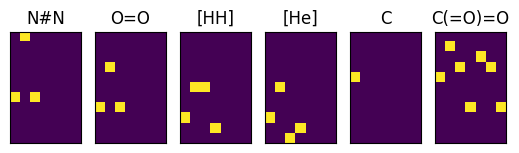

In [8]:
# visualize the encodings

def make_plot(ax,mol,Arr):
    ax.imshow(Arr.T)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_title(mol)
    plt.grid(True,which='minor',color='w')

fig, axs = plt.subplots(1,len(mols))

for i, (mol,Arr) in enumerate(zip(mols,featArr)):
    make_plot(axs[i],mol,Arr)

# Importing some data
The first we will do is just get our hands on some chemical structures to muck around with. We will use a dataset derived from the "Toxicology in the 21st Century" initiative. This contains qualitative toxicitity measurements for ~8000 compounds for 12 different targets (e.g., nuclear receptors and stress response pathways for different stuff). Use the following cell to load and preview the data. All of the columns beginning `NR-` or `SR-` are potential labels, while we plan to convert the `smiles` column into features

In [9]:
data        = pd.read_csv("tox21.csv")
data.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


Now, we are going to extract just the SMILES strings and demonstrate a nice little utility to create molecular structures. Is that necessary? No. Is it something we can do? Watch and find out.

In [10]:
label  = 'NR-AR'
exdata = data[['smiles',label]]
PT.AddMoleculeColumnToFrame(exdata,smilesCol='smiles',includeFingerprints=False)
exdata.head()

[21:00:00] WARNING: not removing hydrogen atom without neighbors
/usr/local/lib/python3.11/dist-packages/rdkit/Chem/PandasTools.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)
Failed to patch pandas - unable to change molecule rendering


,smiles,NR-AR,ROMol
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,<rdkit.Chem.rdchem.Mol object at 0x78ac4b71f610>
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0,<rdkit.Chem.rdchem.Mol object at 0x78ac496b9bd0>
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,NaN,<rdkit.Chem.rdchem.Mol object at 0x78ac496b9c40>
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,<rdkit.Chem.rdchem.Mol object at 0x78ac496b9540>
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,<rdkit.Chem.rdchem.Mol object at 0x78ac496b9cb0>


Notice that some of the data above contains NaN -- probably because there is not data for that label for that molecule. We can eliminate these entries from the dataframe. Then we will make a little diagram to illustrate the toxicity values along with the molecular structures.

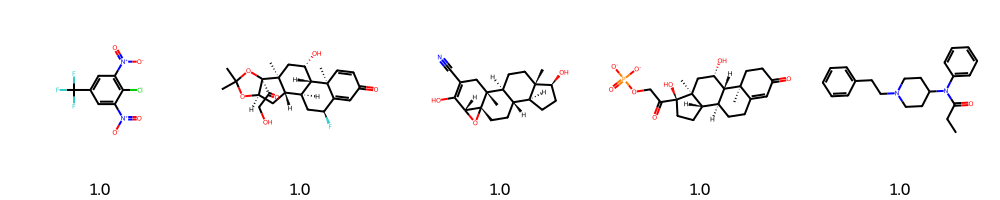

In [11]:
exdata= exdata[~exdata['ROMol'].isnull()]
exdata= exdata[~exdata[label].isnull()]
exdata.head()
display(PT.FrameToGridImage(exdata[exdata[label]>0.95].head(5), legendsCol=label, molsPerRow=5))

## RDKit Molecules
Now it's time to stop fooling around and get down to business. The first thing we are going to do is introduce how to convert SMILES into molecule objects in RDKit. Once we have a molecule object, RDKit can be used for many things. Is there any good way to know everything that can be done within RDKit? Not really... A lot of jumping around on doc pages, tutorials, and trial-and-error.


CCOc1ccc2nc(S(N)(=O)=O)sc2c1
AddConformer
ClearComputedProps
ClearProp
Compute2DCoords
ComputeGasteigerCharges
Debug
GetAromaticAtoms
GetAtomWithIdx
GetAtoms
GetAtomsMatchingQuery
GetBondBetweenAtoms
GetBondWithIdx
GetBonds
GetBoolProp
GetConformer
GetConformers
GetDoubleProp
GetIntProp
GetNumAtoms
GetNumBonds
GetNumConformers
GetNumHeavyAtoms
GetProp
GetPropNames
GetPropsAsDict
GetRingInfo
GetStereoGroups
GetSubstructMatch
GetSubstructMatches
GetUnsignedProp
HasProp
HasSubstructMatch
NeedsUpdatePropertyCache
RemoveAllConformers
RemoveConformer
SetBoolProp
SetDoubleProp
SetIntProp
SetProp
SetUnsignedProp
ToBinary
UpdatePropertyCache
__DebugMol
__GetSubstructMatch
__GetSubstructMatches
__class__
__copy__
__deepcopy__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattribute__
__getinitargs__
__getstate__
__getstate_manages_dict__
__gt__
__hash__
__init__
__init_subclass__
__instance_size__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__saf

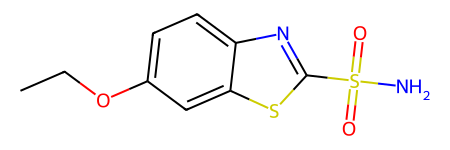

In [12]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
exampleStr = exdata['smiles'][0]
exampleMol = Chem.MolFromSmiles(exampleStr)
print(exampleStr)

# Here I will show how to check what types of methods exist
# within the molecule object.
mol_methods = [method_name for method_name in dir(exampleMol)]
for mol_method in mol_methods:
    print(mol_method)
exampleMol

Molecules are made of atoms and these also have properties

In [13]:
ringStuff = exampleMol.GetRingInfo()
for atom in exampleMol.GetAtoms():
    num = atom.GetAtomicNum()
    idx = atom.GetIdx()
    ri  = ringStuff.NumAtomRings(idx)
    print("Atom {} with atomic number {} is in {} rings".format(idx,num,ri))

Atom 0 with atomic number 6 is in 0 rings
Atom 1 with atomic number 6 is in 0 rings
Atom 2 with atomic number 8 is in 0 rings
Atom 3 with atomic number 6 is in 1 rings
Atom 4 with atomic number 6 is in 1 rings
Atom 5 with atomic number 6 is in 1 rings
Atom 6 with atomic number 6 is in 2 rings
Atom 7 with atomic number 7 is in 1 rings
Atom 8 with atomic number 6 is in 1 rings
Atom 9 with atomic number 16 is in 0 rings
Atom 10 with atomic number 7 is in 0 rings
Atom 11 with atomic number 8 is in 0 rings
Atom 12 with atomic number 8 is in 0 rings
Atom 13 with atomic number 16 is in 1 rings
Atom 14 with atomic number 6 is in 2 rings
Atom 15 with atomic number 6 is in 1 rings


## Fingerprints
OK, so RDKit can be pretty useful for all kinds of random things (e.g., creating automated images of molecules, identifying substructures, and so on.) As it goes for machine learning, two areas of emphasis will be in the acquisition of fingerprints and molecular descriptors. RDKit offers a few different kind of fingerprints. The `RDKit fingerprint` is something akin to the `Daylight fingerprint` -- but it is not that. Meanwhile, you can also use `Morgan fingerprints`. Below we will demonstrate the generation of these fingerprints while adding a second example molecule so we can compute similarities.

O=S(=O)(Cl)c1ccccc1


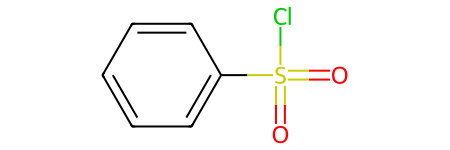

In [24]:
exampleStr = exdata['smiles'][6]
exampleMol2 = Chem.MolFromSmiles(exampleStr)
print(exampleStr)
exampleMol2

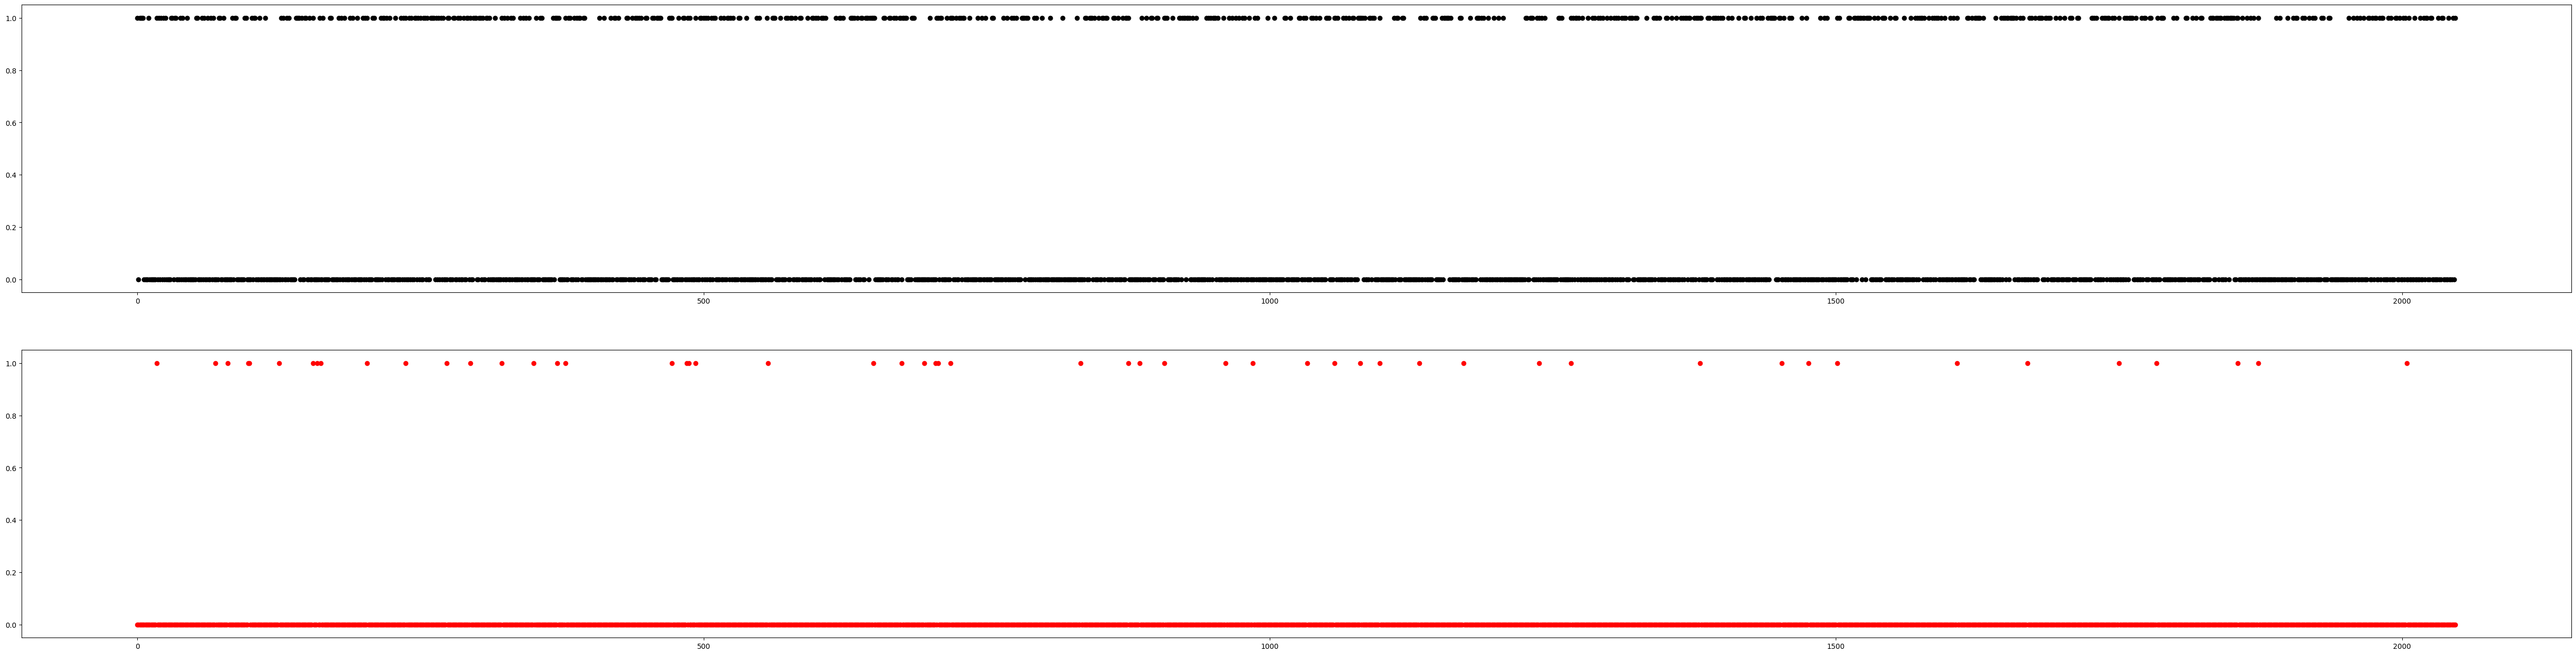

In [25]:
# Now we will create fingerprints.
mols = [exampleMol, exampleMol2] # just a list of molecule objects

# Create fingerprint objects
# fingerprint objects contain a set of operations; because fps may be sparse
# they are packaged in classes that may not be directly usable for ML applications
# we can convert them to numpy arrays though if that is our purpose

#These are the fingerprints
RDfps= [Chem.RDKFingerprint(m) for m in mols] # list of RDKit fingerprints
Mfps = [Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(m,4) for m in mols]

# these are output to numpy arrays
RDvecs = [np.array(fp) for fp in RDfps]
Mvecs  = [np.array(fp) for fp in Mfps ]

# We can see that these fingerprints are very different
fig,ax = plt.subplots(2,1)
fig.set_size_inches(64,16)
ax[0].plot(RDvecs[0],'ok')
ax[1].plot(Mvecs[0],'or')

## Similarity Calculations
One thing that can be useful is to express measures of similarity for molecules. There are numerous metrics that are floating around for doing things of this kind. As far as their documentation reports, RDKit enables facile calculation of the following similarity metrics: `Tanimoto, Dice, Cosine, Sokal, Russel, Kulczynski, McConnaughey, and Tversky`
Inspecting the methods under `DataStructs` seems to suggest that they have even more beyond this.

In the following we will make a comparison of similarities for some different metrics, as well as the different fingerprints.

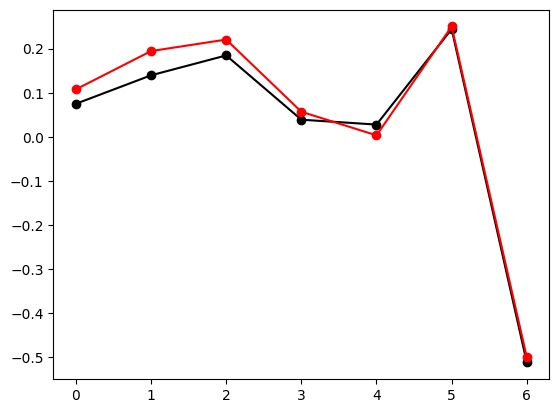

In [26]:
from rdkit import DataStructs
metType   = ['Tanimoto', 'Dice', 'Cosine', 'Sokal', 'Russel', 'Kulczynski','McConnaughey']
simScores = np.zeros((2,len(metType)))

# ordinarily you would invoke a call to the method like
# DataStructs.FingerprintSimilarity(Mfps[0],Mfps[1],   metric=DataStructs.DiceSimilarity)
# to iterate over the strings contained within metType, I will recognize that this things are classes with attributes
for i,metric in enumerate(metType):
    metricName = metric + "Similarity"
    simScores[0,i] = DataStructs.FingerprintSimilarity(RDfps[0],RDfps[1], metric=getattr(DataStructs,metricName))
    simScores[1,i] = DataStructs.FingerprintSimilarity(Mfps[0],Mfps[1], metric=getattr(DataStructs,metricName))

plt.plot(simScores[0,:],'-ok')
plt.plot(simScores[1,:],'-or')
# https://jcheminf.biomedcentral.com/articles/10.1186/s13321-015-0069-3

## Descriptors in RDKit
From molecule objects, we can also compute descriptors using RDKit. There are probably a zillion ways to go about doing this but there is a reasonable module `rdkit.Chem.rdMolDescriptors` that has a list of different things that can be computed. These can range from simple functions of connectivity/chemistry to geomteric descriptions and approximate surface area calculations; some don't even have documentation but still exists. We will just demonstrate a couple of these.

[21:30:23] WARNING: not removing hydrogen atom without neighbors


Examples of LASA


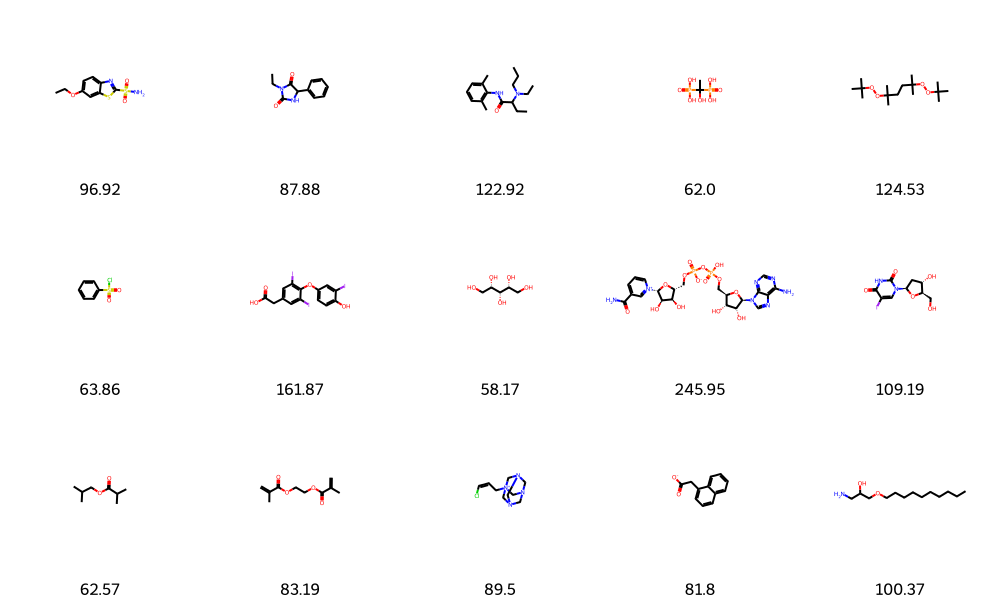


 Examples of Number of Rings


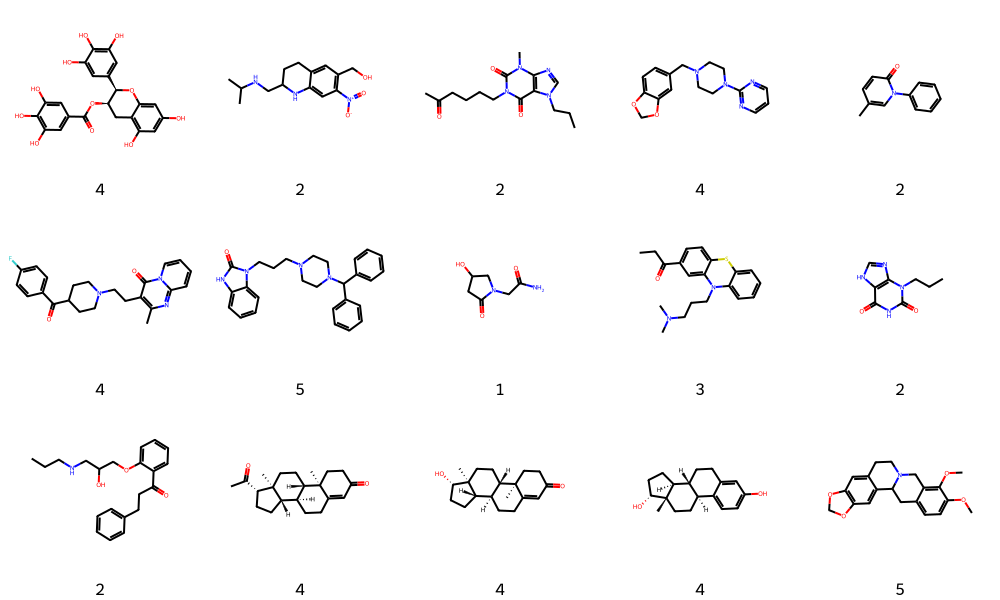

,ROMol
0,<rdkit.Chem.rdchem.Mol object at 0x78ac4b71f610>
1,<rdkit.Chem.rdchem.Mol object at 0x78ac496b9bd0>
3,<rdkit.Chem.rdchem.Mol object at 0x78ac496b9540>
4,<rdkit.Chem.rdchem.Mol object at 0x78ac496b9cb0>
5,<rdkit.Chem.rdchem.Mol object at 0x78ac496b9d20>


In [27]:
# Below we compute the "Labute Accessible Surface Area", Number of Rings, and Number of Rotatable bonds
LASA = [0.0 for i in range(exdata.shape[0])]
NR   = [0.0 for i in range(exdata.shape[0])]
NRB  = [0.0 for i in range(exdata.shape[0])]
for i,smiles in enumerate(exdata['smiles']):
    mol = Chem.MolFromSmiles(smiles)
    LASA[i] = np.round(Chem.rdMolDescriptors.CalcLabuteASA(mol),2)
    NR[i]   = Chem.rdMolDescriptors.CalcNumRings(mol)
    NRB[i]  = Chem.rdMolDescriptors.CalcNumRotatableBonds(mol)

exdata['LASA'] = LASA
exdata['NR']  = NR
exdata['NRB'] = NRB
##Remove nans
#exdata = exdata[~exdata['LASA'].isnull()]
#exdata = exdata[~exdata['NR'].isnull()]
#exdata = exdata[~exdata['NRB'].isnull()]

pd.options.display.float_format = "{:,.2f}".format
print("Examples of LASA")
display(PT.FrameToGridImage(exdata.head(15), legendsCol='LASA', molsPerRow=5))
print("\n Examples of Number of Rings")
display(PT.FrameToGridImage(exdata.tail(15), legendsCol='NR', molsPerRow=5))

exdata['ROMol'].head()

## Using Fingerprints as Features
In the previous few cells, our features were defined by a vector of descriptors, many of which are derived from the chemical structure. It would seem possible that we could train machine learning models to learn directly from a description of the chemical structure itself. Let's try it!

In [ ]:
fps = []
for i,smiles in enumerate(exdata['smiles']):
    mol = Chem.MolFromSmiles(smiles)
    fps.append(Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol,5))
    #fps.append(Chem.RDKFingerprint(mol))

features = np.array(fps)
print(features.shape)

As you can see above, the default size of the fingerprint is 2048-dimensions... that would necessitate a whole lot of parameters for our machine learning model. Let's take a look at one of these fingerprints.

In [ ]:
print(list(fps[0]))
print(list(fps[1]))

Hmmm, a lot of ones and zeros that indicate the presence or lack of some chemical substructure (roughly speaking)... It can sometimes be the case that *none* of the molecules in our dataset feature some substructures that might be described in this 2048-dimensional substructure, suggesting that this element is zero across our dataset. Conversely, perhaps it is possible that an element is always one for *all* of the molecules in the dataset. From an ML perspective, these input elements would never differ for any feature vector and thus represent a constant to the model. So we can screen for these to potentially reduce the dimensionality of the feature vector.

In [ ]:
# to figure out if there are any constant elements we will sum all of our fingerprints
# any bit that remains zero means that it is zero for everything
# any bit that equals the number of data points means it is one for everything
featureSum = np.sum(features,axis=0)
alwaysOn   = featureSum > features.shape[0]-0.01
alwaysOff  = featureSum < 0.5
print("There are {:>4d} elements that are always on".format(np.sum(alwaysOn)))
print("There are {:>4d} elements that are always off".format(np.sum(alwaysOff)))

Seems like this isn't the case here, indicating a pretty diverse set of structures. Now let's try out some learning.

In [ ]:
from sklearn.neural_network import MLPClassifier
labels  = np.array(exdata[label]).reshape([-1,1])

X_train,X_test,y_train,y_test = train_test_split(features,labels,test_size = 0.2)
clf = MLPClassifier(hidden_layer_sizes=[1000,500,250]).fit(X_train, y_train)
y_pred = np.round(clf.predict_proba(X_test)[:,1],0)
C = sklm.confusion_matrix(np.squeeze(y_test),y_pred)
print((roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]), clf.score(X_train,y_train),clf.score(X_test,y_test)))
print(C)